# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.435937,False,-2.602861
1,-0.023840,False,0.187520
2,1.144905,False,2.856077
3,-1.348634,False,-2.331157
4,0.821142,False,0.450725
...,...,...,...
995,0.262037,False,0.596452
996,-0.850738,False,-0.520455
997,0.438321,True,3.706115
998,0.196429,False,-0.889204


<AxesSubplot:xlabel='v0'>

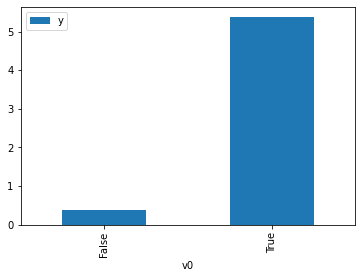

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

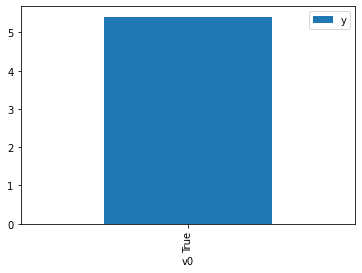

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.769647,False,1.946404,0.309126,3.234922
1,0.260487,False,1.187148,0.417213,2.396857
2,0.180027,False,-1.254071,0.435374,2.296873
3,0.567149,False,-0.165478,0.350398,2.853898
4,0.965659,False,1.116121,0.271874,3.678174
...,...,...,...,...,...
995,-0.190760,False,-0.611644,0.520563,1.920996
996,-0.496658,False,-1.372347,0.590168,1.694433
997,-0.484362,False,-0.411002,0.587420,1.702360
998,-0.290685,False,-0.351290,0.543524,1.839847


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.961217,True,6.449553,0.727314,1.374923
1,2.016325,True,11.071173,0.875986,1.141571
2,-0.379722,True,2.877682,0.436170,2.292685
3,-1.112959,True,3.322205,0.282208,3.543491
4,0.045757,True,5.945634,0.533952,1.872827
...,...,...,...,...,...
995,1.351583,True,6.850038,0.792714,1.261489
996,0.211928,True,4.702118,0.571850,1.748711
997,0.299511,True,5.834901,0.591519,1.690564
998,1.519091,True,7.682372,0.816974,1.224028


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.955
Model:                            OLS   Adj. R-squared (uncentered):              0.955
Method:                 Least Squares   F-statistic:                          1.065e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        04:27:18   Log-Likelihood:                         -1468.3
No. Observations:                1000   AIC:                                      2941.
Df Residuals:                     998   BIC:                                      2951.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8093      0.036     49.886      0.000       1.738       1.880
x2             4.9694      0.049    101.410      0.000       4.873       5.066
==============================================================================
Omnibus:                        0.964   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.617   Jarque-Bera (JB):                0.842
Skew:                          -0.007   Prob(JB):                        0.656
Kurtosis:                       3.141   Cond. No.                         1.76
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""